In [1]:

# Author: Shilin Zhang
# Created Date: 13 June 2022

# Description:
# Replication work of the paper: 
# Optimal selection of time lags for TDSEP based on genetic algorithm

# Related Paper:
# TDSEP - an efficient algorithm for blind separation using time structure

# Method of determning the optimal lag: 
# Indenpendent Component Analysis (ICA)
# Genetic Algorithm (GA)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import yfinance as yf
from numpy.random import randint
from numpy.random import rand

In [3]:
# read the data from yahoo finance
startdate = '2012-04-01'
enddate = '2020-05-01'
datasource = 'SPY'
data = yf.download(datasource,start = startdate,end = enddate)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-04-02,140.639999,142.210007,140.360001,141.839996,116.761993,151741100
2012-04-03,141.639999,141.880005,140.429993,141.259995,116.284546,155806700
2012-04-04,140.220001,140.339996,139.339996,139.860001,115.132065,146896000
2012-04-05,139.380005,140.199997,139.259995,139.789993,115.074455,137439400
2012-04-09,138.029999,139.839996,137.839996,138.220001,113.782043,127555900
...,...,...,...,...,...,...
2020-04-24,280.730011,283.700012,278.500000,282.970001,273.704041,85063200
2020-04-27,285.119995,288.269989,284.619995,287.049988,277.650421,77896600
2020-04-28,291.019989,291.399994,285.399994,285.730011,276.373688,105270000


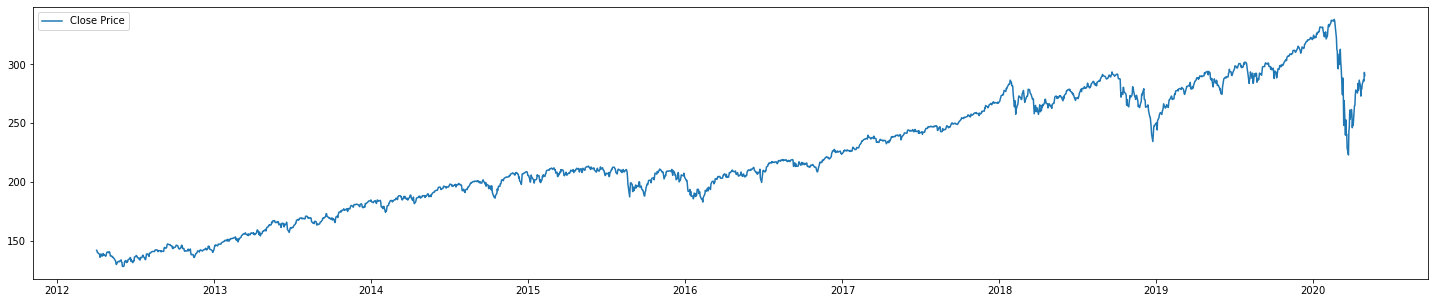

In [5]:
plot.figure(figsize=(25,5))
plot.plot(data['Close'],label='Close Price')
plot.legend()

In [6]:
# observations matrix X

from sklearn.preprocessing import MinMaxScaler

cols = ['Open', 'High', 'Low', 'Adj Close','Volume','Close']
mmscaler = MinMaxScaler()
data[cols] = mmscaler.fit_transform(data[cols])
X = data[cols].to_numpy()
X = X.T

In [7]:
X.shape

(6, 2033)

In [8]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean

# calculate the covariance matrix of six observed time series
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

In [9]:
def whiten(X):
    # Calculate the covariance matrix
    covarMatrix = covariance(X)

    # Single value decoposition
    U, S, V = np.linalg.svd(covarMatrix)

    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))

    # Project onto whitening matrix
    Z = np.dot(whiteM, X)

    return Z, whiteM

In [10]:
X_center, meanX = center(X)

In [11]:
X_center

array([[-0.3827207 , -0.37795743, -0.38472126, ...,  0.33357911,
         0.33600843,  0.33686578],
       [-0.3795683 , -0.3811372 , -0.38845872, ...,  0.32971191,
         0.34625661,  0.33884006],
       [-0.37790215, -0.3775694 , -0.38275146, ...,  0.31164803,
         0.33546665,  0.32681396],
       [-0.37633345, -0.37850468, -0.3837457 , ...,  0.34951574,
         0.38241793,  0.3704093 ],
       [ 0.09462508,  0.10297377,  0.08467568, ..., -0.00080316,
         0.02686894,  0.03540347],
       [-0.37664865, -0.37940742, -0.38606644, ...,  0.30775974,
         0.34333804,  0.33035297]])

In [12]:
Z,whiteM = whiten(X_center)

In [13]:
Z

array([[-1.42527932, -0.32459701, -0.45149751, ...,  2.77609461,
        -0.78110918,  1.0205892 ],
       [-0.85756075, -1.51976566, -1.58487135, ...,  1.18488764,
         0.30851946, -0.03450574],
       [-0.62666348, -0.7067289 , -0.54821603, ..., -0.817971  ,
         0.87103875,  0.26110531],
       [ 0.09914087,  0.03724348,  0.1815309 , ...,  2.25152614,
         2.84878296,  2.63814874],
       [ 0.38987021,  0.48921601,  0.29960862, ...,  0.31578971,
         0.73297246,  0.79049955],
       [-0.6581346 , -0.93997167, -1.13845933, ..., -2.38642989,
         0.03605729, -0.66852944]])

In [14]:
print(np.round(covariance(Z)))

[[ 1. -0. -0.  0. -0.  0.]
 [-0.  1. -0. -0.  0.  0.]
 [-0. -0.  1.  0.  0. -0.]
 [ 0. -0.  0.  1.  0.  0.]
 [-0.  0.  0.  0.  1. -0.]
 [ 0.  0. -0.  0. -0.  1.]]


In [15]:
Z.shape

(6, 2033)

In [16]:
# Independent Component Analysis
# X = S * A.T
# By using ICA, we could approximate original signal matrix S

from sklearn.decomposition import FastICA

transformer = FastICA(n_components=6,
                      random_state=0,
                      whiten='unit-variance',
                      fun='logcosh')
S = transformer.fit_transform(X.T).T

In [17]:
S.shape

(6, 2033)

In [18]:
# Calculate Rotation Matrix Q

# covariance matrix of Z with tau  = Q_T * covariance matrix of S with tau * Q
# TDSEP - an efficient algorithm for blind separation using time structure

# Calculate the average covariance matrix with a list of lags

def covariance_with_lag(x,lags):
    matrix = np.empty((6, 6), float)
    for i in lags:
        x1 = x[:,i:n]
        x2 = x[:,0:n-lag]
        mean1 = np.mean(x1, axis=1, keepdims=True)
        mean1 = np.mean(x2, axis=1, keepdims=True)
        n = np.shape(x1)[1] - 1
        m1 = x1 - mean1
        m2 = x2 - mean2
        matrix = matrix + m1.dot(m2.T)/n
    return matrix/len(lag)

# Compute the orthogonal matrix Q via approximate simultaneous diagonalization

def generate_Q(Z,lags):
    # Set a fixed Q for testing
    Q = np.array([[1,0,0,0,0,0],
     [0,1,0,0,0,0],
     [0,0,1,0,0,0],
     [0,0,0,1,0,0],
     [0,0,0,0,1,0],
     [0,0,0,0,0,1]])
    return Q

In [19]:
# Negentropy Estimation

# One of the estimation function G1 
def G(x):
    return 1/a_1 * np.cosh(a_1 * x)

def J(Y):
    row,col = Y.shape
    J = 0
    for i in range(0,col):
        sum1 = 0
        sum2 = 0
        for j in Y[:,i]:
            sum1 = sum1 + G(j)
            v = np.random.normal(0,1)
            sum2 = sum2 + + G(v)
        E_Y = sum1/row
        E_V = sum2/row
        J = J + (E_Y - E_V) ** 2
    return J

In [20]:
# genetic algorithm search for optimization problem


# objective function
def obj(x):
    Q = generate_Q(Z,x)
    Y = Q @ Z
    result  = n_d * J(Y)/sum(x)
    return -result

# tournament selection
def selection(pop, scores, k=3):
    # first random selection
    selection_ix = randint(len(pop))
    for ix in randint(0, len(pop), k-1):
        # check if better (e.g. perform a tournament)
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

# crossover two parents to create two children
def crossover(p1, p2, r_cross):
    # children are copies of parents by default
    c1, c2 = p1.copy(), p2.copy()
    # check for recombination
    if rand() < r_cross:
        # select crossover point that is not on the end of the string
        pt = randint(1, len(p1)-2)
        # perform crossover
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    return [c1, c2]

# mutation operator
def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        # check for a mutation
        if rand() < r_mut:
            # flip the bit
            bitstring[i] = 1 - bitstring[i]

In [21]:
# genetic algorithm

def genetic_algorithm(objective, n_bits, n_iter, n_pop, r_cross, r_mut):
    # initial population of random bitstring
    pop = [randint(0, 2, n_bits).tolist() for _ in range(n_pop)]
    # keep track of best solution
    best, best_eval = 0, objective(pop[0])
    # enumerate generations
    for gen in range(n_iter):
        # evaluate all candidates in the population
        scores = [objective(c) for c in pop]
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                # print(">%d, new best f(%s) = %.3f" % (gen,  pop[i], scores[i]))
                print("iteration: %d, number of lags: %d, score: %.3f" %(gen, sum(pop[i]), scores[i]))
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
            # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]

In [22]:
# Parameter Setting

# length of an individual/ maximum tau
n_d = 100
# number of generation
n_g = 500
# number of population
n_p = 100
# crossover prob
p_c = 0.85
# mutation prob
p_m = 0.05

# parameter for negentropy estimation
a_1 = 1.5


In [23]:
best, score = genetic_algorithm(obj, n_d, n_g, n_p, p_c, p_m)
print('Done!')
print('f(%s) = %f' % (best, score))

iteration: 0, number of lags: 53, score: -607059872637469.375
iteration: 0, number of lags: 51, score: -630866085654810.875
iteration: 0, number of lags: 46, score: -699438551000677.500
iteration: 0, number of lags: 45, score: -714981705381323.000
iteration: 0, number of lags: 44, score: -731231206864177.125
iteration: 0, number of lags: 44, score: -731231265002576.875
iteration: 0, number of lags: 43, score: -748236631907756.500
iteration: 0, number of lags: 42, score: -766051774904596.125
iteration: 0, number of lags: 41, score: -784735981351244.375
iteration: 0, number of lags: 40, score: -804354448193600.750
iteration: 1, number of lags: 39, score: -824978915844596.875
iteration: 1, number of lags: 38, score: -846688867068674.500
iteration: 2, number of lags: 38, score: -846688874962811.750
iteration: 2, number of lags: 36, score: -893726968842642.625
iteration: 2, number of lags: 36, score: -893727105716985.500
iteration: 3, number of lags: 36, score: -893727128762695.625
iteratio

In [24]:
table = pd.DataFrame(best,columns = ['lag'])

best_lag_list = []
for i in range(0,100):
    if table.iloc[i][0] == 1:
        best_lag_list.append(i+1)
        
best_lag_list

[6, 7, 9, 17, 21, 30, 31, 55, 60, 75, 76, 93]

### Traning/Testing Set Preparation

Calculate the rotation matrix Q for training set
Calculate indepdent component matrix Y for training set
Using the lags trained from the previous step and  indepdent component matrix Y to construct the prediction model input

In [25]:
# Prepare the training and testing data set (80:20)
from pathlib import Path

startdate_training = '2012-04-01'
enddate_training = '2020-05-01'
startdate_testing = '2020-05-01'
enddate_testing = '2022-06-01'
datasource = 'SPY'

data_comparison = yf.download(datasource,start = startdate_training,end = enddate_testing)
filepath = Path('C:/Users/82422/OneDrive/internship/Optimal_Lag/Data/Data_Comparison.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)
data_comparison.to_csv(filepath)

training_set = yf.download(datasource,start = startdate_training,end = enddate_training)
testing_set = yf.download(datasource,start = startdate_testing,end = enddate_testing)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [26]:
def training_preparation(training_set,lags):
    cols = ['Open', 'High', 'Low', 'Adj Close','Volume','Close']
    mmscaler = MinMaxScaler()
    training_set[cols] = mmscaler.fit_transform(training_set[cols])
    X = training_set[cols].to_numpy()
    X = X.T
    
    X_center, meanX = center(X)
    Z,whiteM = whiten(X_center)

    Q = generate_Q(Z,lags)
    Y = Q @ Z
    return Q,Y.T

In [27]:
Q_training, Y_training = training_preparation(training_set,best_lag_list)

In [28]:
Y_training

array([[-1.42527802, -0.8575554 , -0.62666321,  0.09912783,  0.38987041,
        -0.65812836],
       [-0.32459705, -1.51976539, -0.70672893,  0.03724348,  0.48921602,
        -0.93997178],
       [-0.45149835, -1.58487403, -0.54821623,  0.18153861,  0.29960853,
        -1.13846323],
       ...,
       [ 2.77609559,  1.18489205, -0.81797071,  2.25151628,  0.31578989,
        -2.3864255 ],
       [-0.78110817,  0.30852417,  0.87103898,  2.84877266,  0.73297266,
         0.03606193],
       [ 1.02058913, -0.03450519,  0.26110533,  2.63814901,  0.79049959,
        -0.66852995]])

In [29]:
Y_training.shape

(2033, 6)

In [30]:
def testing_preparation(testing_set,Q_training):
    cols = ['Open', 'High', 'Low', 'Adj Close','Volume','Close']
    mmscaler = MinMaxScaler()
    testing_set[cols] = mmscaler.fit_transform(testing_set[cols])
    X = testing_set[cols].to_numpy()
    X = X.T
    
    X_center, meanX = center(X)
    Z,whiteM = whiten(X_center)
    Z
    Q = Q_training
    Y = Q @ Z
    return Y.T

In [31]:
Y_testing = testing_preparation(testing_set,Q_training)

In [32]:
Y_testing.shape

(526, 6)

In [37]:
# Generate the input matrix according to the best lag list

def rearrange(Y,lags):
    ncol = (Y.shape[1] - 1) * len(lags)
    nrow = Y.shape[0] - n_d
    Y_re = np.empty((nrow, ncol), float)
    
    for i in range(0,nrow):
        for j in range(0,ncol):
            for k in lags:
                Y_re[i][j] = Y[i+k-1][j%5]
                    
    Y_re = np.concatenate((Y_re, Y[n_d:,(Y.shape[1] - 1):].reshape(Y.shape[0] - n_d,1)), axis = 1)
    return Y_re

In [34]:
Y_training_re = rearrange(Y_training,best_lag_list)

In [38]:
Y_testing_re = rearrange(Y_testing,best_lag_list)

In [39]:
# save training set and testing set as csv file

training_df = pd.DataFrame(Y_training_re)
testing_df = pd.DataFrame(Y_testing_re)

In [40]:
testing_df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,1.132390,1.403145,-2.034062,-2.105847,0.085830,1.132390,1.403145,-2.034062,-2.105847,0.085830,...,1.403145,-2.034062,-2.105847,0.085830,1.132390,1.403145,-2.034062,-2.105847,0.085830,-0.461086
1,0.286420,-0.575649,-1.269527,-1.052335,0.030823,0.286420,-0.575649,-1.269527,-1.052335,0.030823,...,-0.575649,-1.269527,-1.052335,0.030823,0.286420,-0.575649,-1.269527,-1.052335,0.030823,-2.057040
2,-0.403094,0.258287,-1.751210,-0.944135,-0.581700,-0.403094,0.258287,-1.751210,-0.944135,-0.581700,...,0.258287,-1.751210,-0.944135,-0.581700,-0.403094,0.258287,-1.751210,-0.944135,-0.581700,-1.204316
3,0.032657,-0.309690,-0.921096,-0.912292,-0.915097,0.032657,-0.309690,-0.921096,-0.912292,-0.915097,...,-0.309690,-0.921096,-0.912292,-0.915097,0.032657,-0.309690,-0.921096,-0.912292,-0.915097,-0.040367
4,-0.366974,0.016696,0.186063,-1.455779,-0.000825,-0.366974,0.016696,0.186063,-1.455779,-0.000825,...,0.016696,0.186063,-1.455779,-0.000825,-0.366974,0.016696,0.186063,-1.455779,-0.000825,-0.949927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,-0.923872,0.126026,-1.069835,2.618213,1.196319,-0.923872,0.126026,-1.069835,2.618213,1.196319,...,0.126026,-1.069835,2.618213,1.196319,-0.923872,0.126026,-1.069835,2.618213,1.196319,-0.909307
422,-1.481035,-0.148776,-0.105428,2.907965,0.628733,-1.481035,-0.148776,-0.105428,2.907965,0.628733,...,-0.148776,-0.105428,2.907965,0.628733,-1.481035,-0.148776,-0.105428,2.907965,0.628733,-1.537379
423,-0.518119,0.365018,-0.060577,2.638569,-0.178470,-0.518119,0.365018,-0.060577,2.638569,-0.178470,...,0.365018,-0.060577,2.638569,-0.178470,-0.518119,0.365018,-0.060577,2.638569,-0.178470,-1.054895
424,0.720089,-1.498979,-1.220125,3.181585,-0.025618,0.720089,-1.498979,-1.220125,3.181585,-0.025618,...,-1.498979,-1.220125,3.181585,-0.025618,0.720089,-1.498979,-1.220125,3.181585,-0.025618,-0.419269


In [41]:
Y_df = pd.concat([training_df,testing_df])

In [42]:
Y_df

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,-0.620386,-0.701528,-1.685470,0.541450,-1.166953,-0.620386,-0.701528,-1.685470,0.541450,-1.166953,...,-0.701528,-1.685470,0.541450,-1.166953,-0.620386,-0.701528,-1.685470,0.541450,-1.166953,-1.590064
1,-0.393741,-0.861469,-1.318460,0.390731,-0.671202,-0.393741,-0.861469,-1.318460,0.390731,-0.671202,...,-0.861469,-1.318460,0.390731,-0.671202,-0.393741,-0.861469,-1.318460,0.390731,-0.671202,-1.075010
2,-1.010061,-0.321602,-1.417338,0.524852,-1.340483,-1.010061,-0.321602,-1.417338,0.524852,-1.340483,...,-0.321602,-1.417338,0.524852,-1.340483,-1.010061,-0.321602,-1.417338,0.524852,-1.340483,-1.670211
3,-1.104561,-0.711703,-1.214235,0.393134,-0.463518,-1.104561,-0.711703,-1.214235,0.393134,-0.463518,...,-0.711703,-1.214235,0.393134,-0.463518,-1.104561,-0.711703,-1.214235,0.393134,-0.463518,-1.547209
4,-0.623846,-0.935707,-1.118261,0.392723,-0.889362,-0.623846,-0.935707,-1.118261,0.392723,-0.889362,...,-0.935707,-1.118261,0.392723,-0.889362,-0.623846,-0.935707,-1.118261,0.392723,-0.889362,-1.564052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,-0.923872,0.126026,-1.069835,2.618213,1.196319,-0.923872,0.126026,-1.069835,2.618213,1.196319,...,0.126026,-1.069835,2.618213,1.196319,-0.923872,0.126026,-1.069835,2.618213,1.196319,-0.909307
422,-1.481035,-0.148776,-0.105428,2.907965,0.628733,-1.481035,-0.148776,-0.105428,2.907965,0.628733,...,-0.148776,-0.105428,2.907965,0.628733,-1.481035,-0.148776,-0.105428,2.907965,0.628733,-1.537379
423,-0.518119,0.365018,-0.060577,2.638569,-0.178470,-0.518119,0.365018,-0.060577,2.638569,-0.178470,...,0.365018,-0.060577,2.638569,-0.178470,-0.518119,0.365018,-0.060577,2.638569,-0.178470,-1.054895
424,0.720089,-1.498979,-1.220125,3.181585,-0.025618,0.720089,-1.498979,-1.220125,3.181585,-0.025618,...,-1.498979,-1.220125,3.181585,-0.025618,0.720089,-1.498979,-1.220125,3.181585,-0.025618,-0.419269


In [43]:
from pathlib import Path  
filepath = Path('C:/Users/82422/OneDrive/internship/Optimal_Lag/Data/Data_Processed.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
Y_df.to_csv(filepath)